<script type="text/x-mathjax-config">

MathJax.Hub.Config({

  tex2jax: {inlineMath: [['$','$'], ['\\(','\\)']]}

});

</script>

<script src='https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.5/latest.js?config=TeX-MML-AM_CHTML' async></script>

## Project8 깊은 인공신경망 모델

### 1. 개요

이번 프로젝트에서는 보다 깊은 인공싱경망을 구현하고, 이러한 인공신경망을 구현하는데 있어 필요한 몇가지 개선점들을 살펴본다.

데이터의 분석과 시각화를 위해서 미리 정의해둔 플로팅 함수들을 사용한다. 해당 함수들은 projectfiles.analyzer.graphics에 정의되어있다.

In [3]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from projectfiles.analyzer.graphics import plot_decision_regions, plot_data
from projectfiles.analyzer.statistics import classification_accuracy

### 2. 다중 분류 문제와 인공신경망

인공신경망을 이용하면 다중 분류 문제 또한 쉽게 해결할 수 있다. 이를 붓꽃 데이터셋을 이용하여 실증적으로 증명하고자 한다.

먼저 데이터셋과 필요한 모듈들을 가져온다.

In [4]:
from projectfiles.annclassifier        import ANNClassifier
from projectfiles.common.optimizers    import SGD
from projectfiles.common.encoder       import one_hot_encoder      # 원-핫 인코더
from projectfiles.common.initializers  import Zeros, RandomNormal  # 초기화 모델


# 데이터셋 다운로드
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None)

y = df.iloc[0:150, 4].values
ynames = {}

for idx, lbl in enumerate(np.unique(y)):
    y[y == lbl] = idx
    ynames[idx] = lbl

# 정답 레이블 인코딩
y_encoded = one_hot_encoder(categorical_features='auto').fit_transform(y, drop_first=False)

X = df.iloc[0:150, [0, 2]].values

# 데이터 표준화
X_std = np.copy(X)
X_std[:, 0] = (X[:, 0] - X[:, 0].mean()) / X[:, 0].std()
X_std[:, 1] = (X[:, 1] - X[:, 1].mean()) / X[:, 1].std()

X_std.shape, y_encoded.shape

((150, 2), (150, 3))

그리고 데이터셋을 학습하기 위한 모델을 생성한다.

In [5]:
# fitting model
input_size   = X_std.shape[1]
output_size  = y_encoded.shape[1]
hidden_size  = 5
random_state = 1

optimizer          = SGD(lr=0.01, momentum=0, decay=0)
kernel_initializer = RandomNormal(mean=0., stddev=0.01, random_state=random_state)
bias_initializer   = Zeros()

model = ANNClassifier(input_size=input_size, hidden_size=hidden_size, output_size=output_size,
                      activation='relu', optimizer=optimizer, loss='cee',
                      kernel_initializer=kernel_initializer,
                      bias_initializer=bias_initializer)
model.fit(X_std, y_encoded, batch_size=100, epochs=500)

이진 분류기 모델에서 출력의 크기가 2였던 이유는 클래스 레이블의 개수가 2개였기 때문이다. 지금 붓꽃 데이터셋의 클래스 레이블 개수는 3개 이므로 출력층의 뉴런 개수는 3개여야 한다. 나머지 요소들은 이전 프로젝트와 동일하다.

최종적으로 모델의 학습결과를 확인한다. 학습결과는 다음과 같다.

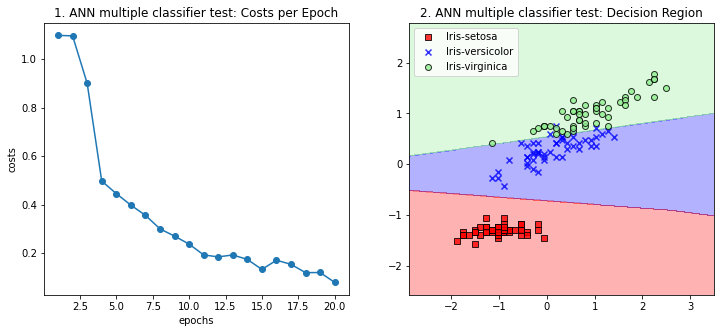

In [6]:
# plotting result
result = plt.figure(figsize=(12, 5))
ax1 = result.add_subplot(1, 2, 1)
ax2 = result.add_subplot(1, 2, 2)

model.plot_costs(ax=ax1, resolution=25)
ax1.set_title('1. ANN multiple classifier test: Costs per Epoch')
ax1.set_xlabel('epochs')
ax1.set_ylabel('costs')

plot_decision_regions(X_std, y, model, resolution=0.01, names=ynames, ax=ax2)
ax2.set_title('2. ANN multiple classifier test: Decision Region')
ax2.legend(loc='upper left')

plt.show()

위의 학습결과를 토대로 인공신경망 모델이 다중 분류 문제 또한 잘 해결함을 확인할 수 있다.

위와 같은 결과는 앞선 프로젝트에서 구현하였던 OvR 분류기로도 유도가 가능하다.

### 3. 깊은 인공신경망 모델

흔히 인공신경망이 깊다고 하기 위해서는 은닉층이 2개 이상이어야 한다. 은닉층이 2개 이상인 깊은 인공신경망 모델에서는 은닉층이 1개인 얕은 모델보다 신경쓸 것이 더 많다.

먼저 극적인 변화를 느끼기 위해 붓꽃 데이터셋이 아닌 다른 데이터셋을 사용한다. 이 데이터셋은 MNIST 손글씨 데이터셋으로 편의상 대중적으로 유명한 인공신경망 라이브러리인 Keras에서 제공하는 데이터를 사용한다. 이 데이터셋에 대한 자세한 설명은 아래 링크를 참조한다.

Keras MINST Hand-writing Dataset: https://keras.io/ko/datasets/#mnist

In [8]:
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.utils import to_categorical


# MNIST 손글씨 데이터셋 학습 알고리즘
# URL: https://keras.io/ko/datasets/#mnist
(x_train, y_train), (x_test, y_test) = load_data()

ynames = {}
for lbl in np.unique(y_train):
    ynames[lbl] = lbl

# 훈련용 클래스 레이블의 원-핫 벡터 인코딩
y_train_encoded = to_categorical(y_train)

# 데이터의 스케일 조정 (0에서 1사이의 값으로)
x_train, x_test = x_train/255.0, x_test/255.0

x_train.shape, y_train_encoded.shape

((60000, 28, 28), (60000, 10))

위의 데이터셋은 3차원 데이터셋이다. 앞서 우리는 2차원 데이터셋만을 다루었기 때문에 해당 데이터셋을 2차원의 형태로 변환해주는 새로운 계층을 다음과 같이 정의한다. 이 계층은 행렬 형태의 각 데이터 샘플을 하나의 벡터 형태로 변환하여 전파한다. 역전파 역시 마찬가지로 벡터 형태의 기울기 정보를 행렬 형태로 변환한다. 해당 계층은 Flatten이라는 이름으로 projectfiles.common.layers에 구현되어있다.

In [9]:
class Flatten(object):
    def __init__(self, input_shape=None):
        self.units       = np.multiply.reduce(input_shape)
        self.input_shape = input_shape  # input size preset
        self.batch_size  = None         # batch size

    def compile(self, random_state=None):
        if self.input_shape is None:
            raise TypeError(f"'input_shape' not defined")

        return self

    def forward(self, x):  # 원본 데이터를 행렬 형태로 변환한다
        out = np.reshape(x, newshape=(x.shape[0], self.units))
        self.batch_size = x.shape[0]

        return out

    def backward(self, dout):  # 기울기 벡터를 행렬 형태로 변환한다
        dx = np.reshape(dout, newshape=(self.batch_size, *self.input_shape))

        return dx

해당 계층을 이용하여 아래와 같이 2차원 데이터 샘플을 벡터 형태로 변환할 수 있다.

In [11]:
model = Flatten(input_shape=(28, 28))
out = model.forward(x_train)

out.shape

(60000, 784)

이제는 위의 계층을 이용하여 MNIST 데이터셋을 학습하기 위한 모델을 구성한다.

In [15]:
from projectfiles.neural_network_model import Sequential
from projectfiles.common.layers        import Dense, Flatten
from projectfiles.common.optimizers    import SGD
from projectfiles.common.initializers  import Zeros, RandomNormal
from projectfiles.analyzer.statistics  import classification_accuracy


# fitting model
random_state = None
optimizer = SGD(lr=0.001, momentum=0, decay=0)
bias_initializer = Zeros()

model = Sequential()
model.add(Flatten(input_shape=(28, 28)))
model.add(Dense(units=512, activation='relu', input_shape=784,
                kernel_initializer=RandomNormal(mean=0., stddev=0.01, random_state=random_state),
                bias_initializer=bias_initializer))
model.add(Dense(units=100, activation='relu', input_shape=512,
                kernel_initializer=RandomNormal(mean=0., stddev=0.01, random_state=random_state),
                bias_initializer=bias_initializer))
model.add(Dense(units=10, activation='softmax', input_shape=100,
                kernel_initializer=RandomNormal(mean=0., stddev=0.01, random_state=random_state),
                bias_initializer=bias_initializer))
model.compile(optimizer=optimizer, loss='cee')
model.fit(x_train, y_train_encoded, batch_size=1000, epochs=200)

위의 모델에서 주의할 점은 제일 앞에 위치할 계층으로 Flatten을 사용했다는 점이다. 그리고 이전에 사용했던 ANN 분류기와는 다르게 Dense 계층이 하나 더 추가되었다. 이 계층인해 위의 모델은 ANN 분류기보다 은닉층이 하나 더 많은 형태를 갖는다.

위의 모델의 학습 결과를 확인해보자.

accuracy: 23.89%


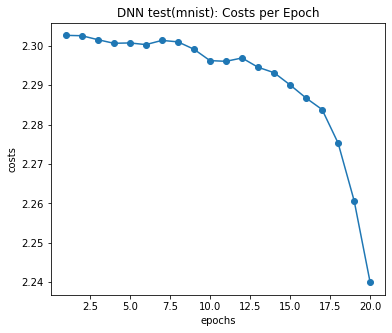

In [16]:
# plotting result
result = plt.figure(figsize=(6, 5))
ax1 = result.add_subplot()

model.plot_costs(ax=ax1, resolution=10)
ax1.set_title('DNN test(mnist): Costs per Epoch')
ax1.set_xlabel('epochs')
ax1.set_ylabel('costs')

# testing
print(f"accuracy: {classification_accuracy(model, x_test, y_test)*100:.2f}%")

plt.show()